# CSCI 381/780 (Fall 2022) - Project 1

**Due Date: Friday, October 7 by 4 PM**

## Description
In this project you will construct machine learning models on a dataset comprised of sociodemographic data of U.S. citizens collected from the 1994 U.S. Census. The machine learning task will be binary classification of people based on their income level being either <= 50,000 USD or > 50,000 USD.

## Instructions
1. In this project you will write code to construct machine learning models using various partitions (see the figure below) of the census dataset and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. There are many Scikit-learn functions that leverage randomness to generate results. For these functions, a pseudorandom generator can be intialized using a seed value by passing the parameter `random_state=XXX`, where `XXX` is some number between 1 and 2^31-1. For each of these functions, **you will utilize your CUNY ID number** to initialize the function. Functions include:
- `StratifiedShuffleSplit`
- `RandomForestClassifier`
- `RandomizedSearchCV`
3. You will **work independently** on the project. Please make use of the *Python Data Science Reference Materials* posted on Blackboard, or come to office hours should you need further assistance.
4. You will submit a single Jupyter notebook containing all code and written responses via Blackboard by the due date listed above. 

<img src="project-1-data-folds.png" width="600" height="300">

## Grading

### Running Code
Your Jupyter notebook must be able to run from start to finish **without error**. Please turn any cell that contains scratch work or other non-executable items to *Raw*. **Notebooks that cannot run to completion will receive a grade of 0**.

### Holdout Set Evaluation
Your final models will be evaluated against a holdout set. You model performances with respect to AUC on this set must be *comparable* (e.g., within 5%) of those reported in Part 6.

### Rubric

|**Part**|0|1|2|3|4|5|6|7|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|15|5|10|20|10|10|20|10|100|


## Part 0: Load Data

Set the variable `CENSUS_FILE` to the **full path** to the census dataset (**census_dataset.csv**) on your system. Load the file into a dataframe (you may intialize the column names using the header list `census_column_names`), then:
1. Determine the number and types of features.
2. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
3. Perform any necessary preprocessing on dataset.
4. Perform a **stratified split** of the data into training/validation/test sets, 60%/20%/20%. 
5. Verify that the training/validation/test splits have the same prevalence as the original dataset.
6. Standardize the training/validation/test splits (fit on the training, then transform the validation/test sets). Use the standardized splits for the SVM models *only*.

In [1]:
import os
import pandas as pd

CENSUS_FILE=r"C:\Users\Polymorph\Desktop\College\Year 4\Fall\381\Project 1\census_dataset.csv"
census_column_names=['age','workclass','fnlwgt','education','education-num',
                      'marital-status','occupation','relationship','race','sex',
                      'capital-gain','capital-loss','hours-per-week','native-country',
                      'annual-income']

def load_census_data(census_file=CENSUS_FILE):
    csv_path = os.path.join(census_file,"census_dataset.csv")
    return pd.read_csv(census_file,names=census_column_names)

census_data = load_census_data()
census_income = census_data['annual-income'].to_list()
census_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
0,73,Unknown,378922,HS-grad,9,Married-spouse-absent,Unknown,Not-in-family,White,Female,0,0,20,Canada,<=50K
1,46,Private,207807,10th,6,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,30,United-States,<=50K
2,55,Self-emp-not-inc,319733,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
3,38,Unknown,365465,Assoc-voc,11,Never-married,Unknown,Own-child,White,Male,0,0,15,United-States,<=50K
4,26,Self-emp-not-inc,33016,Assoc-voc,11,Divorced,Other-service,Unmarried,White,Female,0,0,55,United-States,<=50K


In [2]:
#describes a DataFrame's columns, nullity, and type
# 1. Determine the number and types of features
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27482 non-null  int64 
 1   workclass       27482 non-null  object
 2   fnlwgt          27482 non-null  int64 
 3   education       27482 non-null  object
 4   education-num   27482 non-null  int64 
 5   marital-status  27482 non-null  object
 6   occupation      27482 non-null  object
 7   relationship    27482 non-null  object
 8   race            27482 non-null  object
 9   sex             27482 non-null  object
 10  capital-gain    27482 non-null  int64 
 11  capital-loss    27482 non-null  int64 
 12  hours-per-week  27482 non-null  int64 
 13  native-country  27482 non-null  object
 14  annual-income   27482 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.1+ MB


In [3]:
census_data['annual-income'].value_counts()

<=50K    19915
>50K      7567
Name: annual-income, dtype: int64

In [4]:
#determine class balance
# 2. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
census_data['annual-income'].value_counts()/len(census_data)

<=50K    0.724656
>50K     0.275344
Name: annual-income, dtype: float64

Does not seem to be balanced <=50k is 0.73 || >50k is 0.28

In [5]:
#calculate summary statistics for numerical features
census_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,27482.000000,2.748200e+04,27482.000000,27482.000000,27482.000000,27482.000000
mean,38.835529,1.892397e+05,10.144640,1244.783131,87.665454,40.605560
std,13.596011,1.046691e+05,2.556306,8052.361951,403.121737,12.426491
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.174818e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.367698e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
#3. Perform any necessary preprocessing on dataset
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
census_data['annual-income'] = census_data['annual-income'].map({ ">50K" : 1, "<=50K" : 0 })
census_data_copy = census_data.copy()
census_data=enc.fit_transform(census_data)
census_data = pd.DataFrame(census_data, index = census_data_copy.index, columns = census_data_copy.columns)

In [7]:
# 4. Perform a stratified split of the data into training/validation/test sets, 60%/20%/20%. 

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=23730704)
for train_index, test_index in split.split(census_data, census_data['annual-income']):
    TrainAndValidation = census_data.iloc[train_index]
    test_set = census_data.loc[test_index]
    
split2 = StratifiedShuffleSplit(n_splits=1,test_size=0.25, random_state=23730704)
for train_index, test_index in split2.split(TrainAndValidation, TrainAndValidation['annual-income']):
    train_set = TrainAndValidation.iloc[train_index]
    validation_set = TrainAndValidation.iloc[test_index]

In [8]:
# Training (60%)+ Validation (20%) + Test (20%)

In [9]:
# Test Data 20%
test_set['annual-income'].value_counts()/len(test_set)


0.0    0.724577
1.0    0.275423
Name: annual-income, dtype: float64

In [10]:
# Training Data 60%
train_set['annual-income'].value_counts()/len(train_set)

0.0    0.724648
1.0    0.275352
Name: annual-income, dtype: float64

In [11]:
# Validation Split 20% 
validation_set['annual-income'].value_counts()/len(validation_set)

0.0    0.724759
1.0    0.275241
Name: annual-income, dtype: float64

In [12]:
# Standardize the training/validation/test splits (fit on the training, 
# then transform the validation/test sets). Use the standardized splits for the SVM models *only*.

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
scaled_train_set = scaler.fit(train_set) 
scaled_train_set = scaler.transform(train_set) 
scaled_valid_set = scaler.transform(validation_set)
scaled_test_set = scaler.transform(test_set)

In [13]:
#Creating dependant and independat variables to be used for training 
from sklearn.model_selection import train_test_split

X_train = train_set.drop(['annual-income'], axis=1)
y_train = train_set['annual-income']

X_validation = validation_set.drop(['annual-income'], axis=1)
y_validation = validation_set['annual-income']

X_test = test_set.drop(['annual-income'], axis=1)
y_test = test_set['annual-income']

In [14]:
from sklearn import preprocessing

trainDB = pd.DataFrame(scaled_train_set, index=train_set.index, columns=train_set.columns)
validDB = pd.DataFrame(scaled_valid_set, index=validation_set.index, columns=validation_set.columns)
testDB = pd.DataFrame(scaled_test_set, index=test_set.index, columns=test_set.columns)

standardize_X_train = trainDB.drop(['annual-income'], axis = 1)
standardize_y_train = trainDB['annual-income']
standardize_y_train[standardize_y_train < 0] = 0
standardize_y_train[standardize_y_train > 0] = 1

standardize_X_validation = validDB.drop(['annual-income'], axis = 1)
standardize_y_validation = validDB['annual-income']
standardize_y_validation[standardize_y_validation < 0] = 0
standardize_y_validation[standardize_y_validation > 0] = 1

standardize_X_test = testDB.drop(['annual-income'], axis = 1)
standardize_y_test = testDB['annual-income']
standardize_y_test[standardize_y_test < 0] = 0
standardize_y_test[standardize_y_test > 0] = 1

## Part 1: Train Initial Models

Using default hyperparameters:
1. Construct **Naive Bayes (NB)**, **Support Vector Machine (SVM)** , and **Random Forest (RF)** models on the training set.
2. Calculate the confusion matrix and report the following performance metrics on the **training set**:
    *Accuracy*, *F1 Score*, *AUC*, *Sensitivity*, *Specificity*, and *Precision*. You can use the function `p1_metrics` for this purpose. Are any of the models underfitting the data? Is so, why?

3. Calculate the same metrics by applying the trained model to the **validation set**. Compare and contrast the errors each model makes in terms of each class. 

In [15]:
# Construct Naive Bayes (NB) models on the training set.
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_train)

print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_train, gnb_y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 81.12566715186803


In [16]:
# Construct Support Vector Machine (SVM) models on the training set.
from sklearn.datasets import make_classification
from sklearn.svm import SVC

SVM_model = SVC()
SVM_model.fit(standardize_X_train, standardize_y_train)
SVM_y_pred = SVM_model.predict(standardize_X_train)

print("Support Vector Machine model accuracy(in %):", metrics.accuracy_score(standardize_y_train, SVM_y_pred)*100)

Support Vector Machine model accuracy(in %): 85.57738961669092


In [17]:
# Construct Random Forest (RF) models on the training set.
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=23730704)
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_train)

print("Random Forest model accuracy(in %):", metrics.accuracy_score(y_train, rfc_y_pred)*100)


Random Forest model accuracy(in %): 99.99393498301795


In [18]:
#peformance metric functions
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import numpy as np

#A list of keys for the dictionary returned by p1_metrics
metric_keys = ['auc','f1','accuracy','sensitivity','specificity', 'precision']

def p1_metrics(y_true,y_pred,include_cm=True):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if include_cm:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp),
            'confusion_matrix': cm}
    else:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p1_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return p1_metrics(y_true,y_pred,include_cm=False)

In [19]:
# 2. Calculate the confusion matrix and report the following performance metrics on the training set: Accuracy, F1 Score, AUC, Sensitivity, Specificity, and Precision. You can use the function p1_metrics for this purpose. Are any of the models underfitting the data? Is so, why?

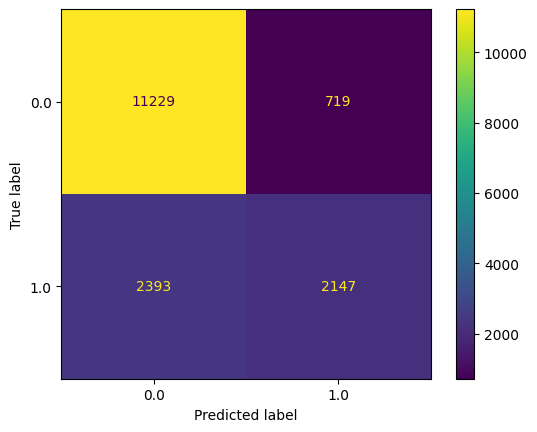

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = p1_metrics(y_train, gnb_y_pred).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

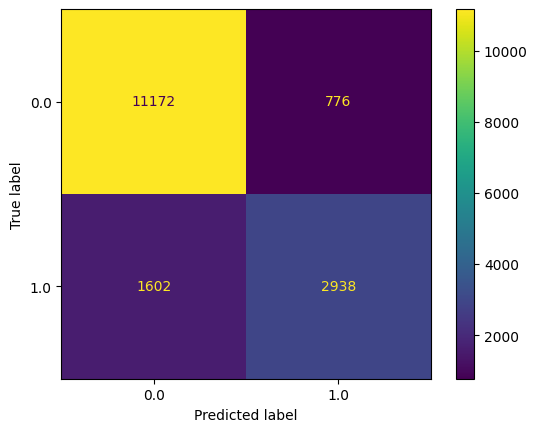

In [21]:
cm = p1_metrics(standardize_y_train, SVM_y_pred).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

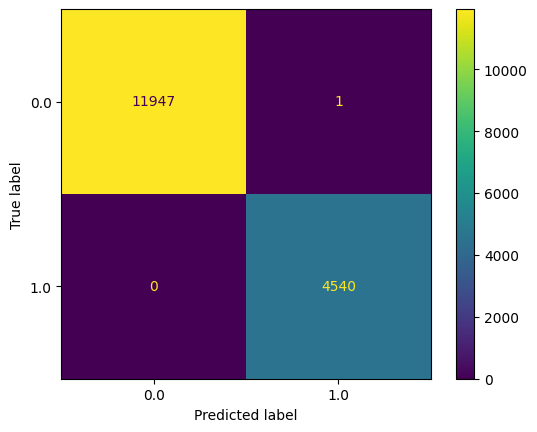

In [22]:
cm = p1_metrics(y_train, rfc_y_pred).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

# Are any of the models underfitting the data? Is so, why?

After training each model there are two clear distinctions to be made. Firstly, the NB model is underfitted in the data. While it does report a 81% accurate model the sensitivity is  is 47% meaning showing that the model is misclasifitying almost half of the data.
The second distinction recorded is that Rf Model is overfitting the data. This is because it is almost perfect accuracy
which should never be happening in machine learning algorithms. It may be beacuse the model is too simple to where it fits too closely to the training set which causes it to perfectly report the data. 

In [23]:
# 3 Calculate the same metrics by applying the trained model to the validation set. Compare and contrast the errors each model makes in terms of each class.

valid_y_pred_gnb = gnb.predict(X_validation)
valid_y_pred_SVM = SVM_model.predict(standardize_X_validation)
valid_y_pred_RF = rfc.predict(X_validation)

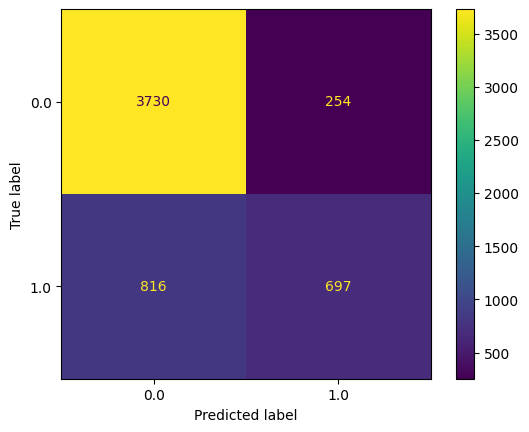

In [24]:
# NB
cm = p1_metrics(y_validation, valid_y_pred_gnb).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

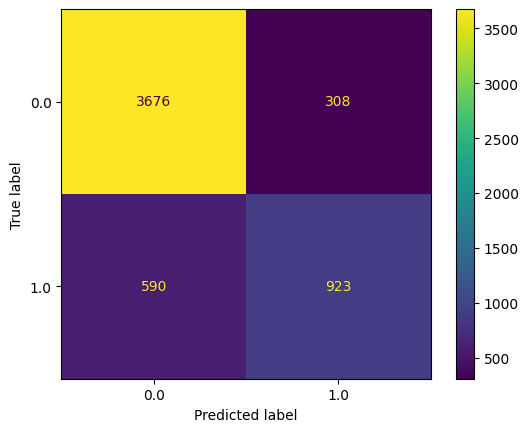

In [25]:
# SVM
cm = p1_metrics(y_validation, valid_y_pred_SVM).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

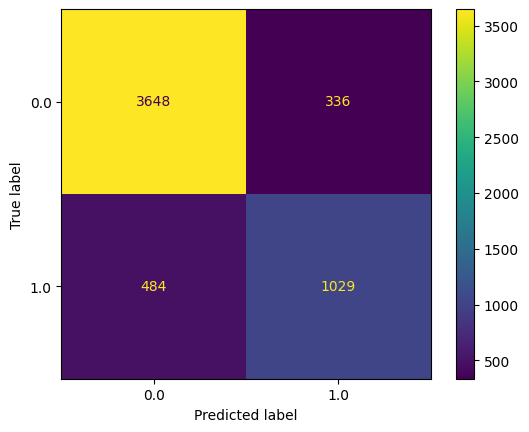

In [26]:
# RF
cm = p1_metrics(y_validation, valid_y_pred_RF).get('confusion_matrix')

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

## Part 2: Cross-Validation Models

Split the **non-test data** (*training* + *validation* data) into **stratified 5-folds** for cross-validation purposes, then:
1. Train NB, SVM, and RF models using 5-fold cross-validation.
2. Report the mean and standard deviation of the performance metrics listed in Part 1.2 for each model. You may use the function `collate_cv_results` for this purpose.
3. How does the performance of these models compare with those created in Part 1? Which models' performances are more consistent, and why?

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model

cv_X = TrainAndValidation.drop('annual-income', axis=1)
cv_y = TrainAndValidation['annual-income']  

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23730704)
nb_score = []
svm_score = []
rf_score = []

gnb_kfold = GaussianNB()
svm_kfold = SVC()
rf_kfold = RandomForestClassifier(random_state=23730704)

for train_index, test_index in skf.split(cv_X, cv_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_kfold, X_test_kfold = cv_X.iloc[train_index], cv_X.iloc[test_index]
    y_train_kfold, y_test_kfold = cv_y.iloc[train_index], cv_y.iloc[test_index]
    
    gnb_kfold.fit(X_train_kfold, y_train_kfold)
    nb_score.append(p1_metrics_scorer(gnb_kfold, X_test_kfold, y_test_kfold))
    rf_kfold.fit(X_train_kfold, y_train_kfold)
    rf_score.append(p1_metrics_scorer(rf_kfold, X_test_kfold, y_test_kfold))

TRAIN: [    0     2     3 ... 21979 21982 21983] TEST: [    1     5    13 ... 21980 21981 21984]
TRAIN: [    0     1     2 ... 21981 21983 21984] TEST: [    6    11    20 ... 21968 21979 21982]
TRAIN: [    0     1     2 ... 21982 21983 21984] TEST: [    8     9    14 ... 21972 21976 21978]
TRAIN: [    1     3     5 ... 21982 21983 21984] TEST: [    0     2     4 ... 21959 21965 21973]
TRAIN: [    0     1     2 ... 21981 21982 21984] TEST: [    3    16    27 ... 21962 21970 21983]


In [28]:
scaled_TrainAndValidation_set = scaler.fit_transform(TrainAndValidation)
TrainAndValidationDB = pd.DataFrame(scaled_TrainAndValidation_set, index=TrainAndValidation.index, columns=TrainAndValidation.columns)


standardize_X_TrainAndValidation = TrainAndValidationDB.drop(['annual-income'], axis = 1)
standardize_y_TrainAndValidation = TrainAndValidationDB['annual-income']
standardize_y_TrainAndValidation[standardize_y_TrainAndValidation < 0] = 0
standardize_y_TrainAndValidation[standardize_y_TrainAndValidation > 0] = 1

SVM_X = standardize_X_TrainAndValidation
SVM_y = standardize_y_TrainAndValidation

for train_index, test_index in skf.split(SVM_X, SVM_y):
    X_train_kfold, X_test_kfold = SVM_X.iloc[train_index], SVM_X.iloc[test_index]
    y_train_kfold, y_test_kfold = SVM_y.iloc[train_index], SVM_y.iloc[test_index]
    
    svm_kfold.fit(X_train_kfold, y_train_kfold)
    svm_score.append(p1_metrics_scorer(svm_kfold, X_test_kfold, y_test_kfold))

In [29]:
# Altered the arrays with appended data to display all the entries under one key for mean calculation 
nb_score = pd.DataFrame(nb_score).to_dict(orient="list")
svm_score = pd.DataFrame(svm_score).to_dict(orient="list")
rf_score = pd.DataFrame(rf_score).to_dict(orient="list")


In [30]:
#Summarizes model performance results produced during cross-validation
def collate_cv_results(cv_results,display=True):
    cv_stats=dict()
    for k in cv_results:
        cv_stats[k+"_mean"]=np.mean(cv_results[k])
        cv_stats[k+"_std"]=np.std(cv_results[k])
        if display:
            print(k,cv_stats[k+"_mean"],"("+str(cv_stats[k+"_std"])+")")
    return cv_stats

In [31]:
nb_mean = collate_cv_results(nb_score)
nb_mean

auc 0.711096570348996 (0.013032112915892187)
f1 0.5872089959129536 (0.022537694387729762)
accuracy 0.8123720718671821 (0.005895602181858433)
sensitivity 0.4857129208153907 (0.028984801624573717)
specificity 0.9364802198826012 (0.0030236553670671892)
precision 0.7437813279740275 (0.0035254037300442467)


{'auc_mean': 0.711096570348996,
 'auc_std': 0.013032112915892187,
 'f1_mean': 0.5872089959129536,
 'f1_std': 0.022537694387729762,
 'accuracy_mean': 0.8123720718671821,
 'accuracy_std': 0.005895602181858433,
 'sensitivity_mean': 0.4857129208153907,
 'sensitivity_std': 0.028984801624573717,
 'specificity_mean': 0.9364802198826012,
 'specificity_std': 0.0030236553670671892,
 'precision_mean': 0.7437813279740275,
 'precision_std': 0.0035254037300442467}

In [32]:
collate_cv_results(svm_score)

auc 0.7767750940596773 (0.009941169466743846)
f1 0.6887191724002131 (0.013608411215219303)
accuracy 0.844166477143507 (0.004299287659192057)
sensitivity 0.626798697886454 (0.02278520443033748)
specificity 0.9267514902329005 (0.0034290016092685433)
precision 0.76481543851747 (0.004184419340429592)


{'auc_mean': 0.7767750940596773,
 'auc_std': 0.009941169466743846,
 'f1_mean': 0.6887191724002131,
 'f1_std': 0.013608411215219303,
 'accuracy_mean': 0.844166477143507,
 'accuracy_std': 0.004299287659192057,
 'sensitivity_mean': 0.626798697886454,
 'sensitivity_std': 0.02278520443033748,
 'specificity_mean': 0.9267514902329005,
 'specificity_std': 0.0034290016092685433,
 'precision_mean': 0.76481543851747,
 'precision_std': 0.004184419340429592}

In [33]:
collate_cv_results(rf_score)

auc 0.8069079876731875 (0.005486839333898937)
f1 0.7300667712666792 (0.007500701638403213)
accuracy 0.8596315669774846 (0.0033560821916209477)
sensitivity 0.6895751752188957 (0.011540515392297153)
specificity 0.9242408001274797 (0.0034122936335537514)
precision 0.7757544023157276 (0.00756571518953594)


{'auc_mean': 0.8069079876731875,
 'auc_std': 0.005486839333898937,
 'f1_mean': 0.7300667712666792,
 'f1_std': 0.007500701638403213,
 'accuracy_mean': 0.8596315669774846,
 'accuracy_std': 0.0033560821916209477,
 'sensitivity_mean': 0.6895751752188957,
 'sensitivity_std': 0.011540515392297153,
 'specificity_mean': 0.9242408001274797,
 'specificity_std': 0.0034122936335537514,
 'precision_mean': 0.7757544023157276,
 'precision_std': 0.00756571518953594}

# How does the performance of these models compare with those created in Part 1? performances are more consistent, and why

Comparing the performance models form part and part 2.  We can see that the metrics reported in part 2 for the SVM and NB
models are slighly better about 1% better for each metric. However for the RF model we can see that the metrics all went way down from the high 90 percentile we were is this is a good thing because before it appeared that the model became too specific for the test data however now with the multiple folds it elimanated tha bias and created a more accuracte result. 

In [34]:
p1_metrics_scorer(gnb, X_validation, y_validation)

{'auc': 0.6984595686115248,
 'f1': 0.5657467532467534,
 'accuracy': 0.8053483718391851,
 'sensitivity': 0.4606741573033708,
 'specificity': 0.9362449799196787,
 'precision': 0.732912723449001}

In [35]:
p1_metrics_scorer(SVM_model, standardize_X_validation, standardize_y_validation)

{'auc': 0.7663685143747495,
 'f1': 0.672740524781341,
 'accuracy': 0.8366381662725123,
 'sensitivity': 0.6100462656972901,
 'specificity': 0.9226907630522089,
 'precision': 0.7497969130787977}

In [36]:
p1_metrics_scorer(rfc, X_validation, y_validation)

{'auc': 0.7978842003838221,
 'f1': 0.7150799166087561,
 'accuracy': 0.8508277242132072,
 'sensitivity': 0.6801057501652347,
 'specificity': 0.9156626506024096,
 'precision': 0.7538461538461538}

## Part 3: SVM Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, you will construct SVM models using the below strategies:
1. Using `GridSearchCV`, determine the best choice of hyperparameters out of the following possible values:
- *Kernel type*: Linear, radial basis function
- *Box constraint (C)*: [1, 5, 10, 20]
- *Kernel width (gamma)*: 'auto','scale'
2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials** using the same possible values for *kernel type* and *kernel width* but with possible **box constraint** values of [1,5,10,15,....,100]. 
4. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters.
5. Compare the performance of the two models (using the metrics in 1.2) as well as the time required to compute the models. Which hyperparameter method do you think is better in this case, and why?

### Please Read!
There are a few parameters for the `GridSearchCV` and `RandomizedSearchCV` functions that should be set:
- `scoring` - This controls the strategy to evaluate the performance of the cross-validated model on the test set, set it to `p1_metrics_scorer`.
- `refit` - This will refit an estimator using the best found parameters on the whole dataset, set it to `"auc"`
- `cv` - This will enable you to reuse your CV splits from Part 2.
    `n_jobs` - Number of jobs to run in parallel, if you have more than one core on your device (you should), set this to as many as you'd like to use, or to `-1` if you want to use all available cores.
- `return_train_score` - Setting this to `False` will reduce computational time.

In [37]:
#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats

In [38]:
from sklearn.model_selection import GridSearchCV
import time 

grid_start = time.time()

parameters = {'kernel':('linear','rbf'), 'C':([1,5,10,20]), 'gamma':('auto', 'scale')}
grd = GridSearchCV(scoring = p1_metrics_scorer, refit = "auc", cv = skf, return_train_score = False, n_jobs=-1, param_grid=parameters, estimator = SVC())
grd.fit(SVM_X, SVM_y)
grid_end = time.time()
grd.best_params_

{'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}

In [39]:
print(grid_end - grid_start, 'seconds')
svm_mean = collate_ht_results(grd)
svm_mean

708.195230960846 seconds
test_auc 0.7844992739221233 (0.009692091990432418)
test_f1 0.6957669385136837 (0.013169136669038873)
test_accuracy 0.8420741414600865 (0.0050601533719075225)
test_sensitivity 0.6563700513884434 (0.020197481040164722)
test_specificity 0.9126284964558034 (0.0017570768621030597)
test_precision 0.7404555423932411 (0.0051894809831871955)


{'auc_mean': 0.7844992739221233,
 'auc_std': 0.009692091990432418,
 'f1_mean': 0.6957669385136837,
 'f1_std': 0.013169136669038873,
 'accuracy_mean': 0.8420741414600865,
 'accuracy_std': 0.0050601533719075225,
 'sensitivity_mean': 0.6563700513884434,
 'sensitivity_std': 0.020197481040164722,
 'specificity_mean': 0.9126284964558034,
 'specificity_std': 0.0017570768621030597,
 'precision_mean': 0.7404555423932411,
 'precision_std': 0.0051894809831871955}

In [40]:
from sklearn.model_selection import RandomizedSearchCV

rscv_start = time.time()

parameters = {'kernel':('linear','rbf'), 'C':([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]), 'gamma':('auto', 'scale')}
rscv = RandomizedSearchCV(scoring = p1_metrics_scorer, refit = "auc", cv = skf, return_train_score = False, n_jobs=-1, param_distributions=parameters, estimator = SVC(), n_iter=16)
rscv.fit(SVM_X, SVM_y)

rscv_end = time.time()
rscv.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 20}

In [41]:
print(rscv_end - rscv_start, 'seconds')
collate_ht_results(rscv)

1801.3704009056091 seconds
test_auc 0.7841061353540623 (0.010115024119941984)
test_f1 0.6951764065827929 (0.013789838527883947)
test_accuracy 0.8418012281100751 (0.005317337642960441)
test_sensitivity 0.6557093038333186 (0.020961113865158032)
test_specificity 0.9125029668748059 (0.001638556047868005)
test_precision 0.7399703157789789 (0.005424354341706846)


{'auc_mean': 0.7841061353540623,
 'auc_std': 0.010115024119941984,
 'f1_mean': 0.6951764065827929,
 'f1_std': 0.013789838527883947,
 'accuracy_mean': 0.8418012281100751,
 'accuracy_std': 0.005317337642960441,
 'sensitivity_mean': 0.6557093038333186,
 'sensitivity_std': 0.020961113865158032,
 'specificity_mean': 0.9125029668748059,
 'specificity_std': 0.001638556047868005,
 'precision_mean': 0.7399703157789789,
 'precision_std': 0.005424354341706846}

# Which hyperparameter method do you think is better in this case, and why?
Comparing the two hyperparameter sets we can see that the hyperparameters we obtained from the randomized search net 
better results slightly. Every metric is a bit higher meaning the hyperparamaters are better however the major con in thisis the time taken to obtain them. The grid search runs much comparatively faster than the randomized search.

So although yes they do net a sligly better result it isn't enough to warrant the time taken to get them. 
If the runtime of these functions are not an issue then the randomized search is better because of the slighty better metrics.

In [42]:
# retraining svm using hyperparemeters from grid search
# {'kernel':('rbf'), 'C':([20]), 'gamma':('auto')}
SVM_model_grd = SVC(C = 20, kernel = 'rbf', gamma = 'auto')
SVM_model_grd.fit(standardize_X_train, standardize_y_train)
SVM_y_pred_grd = SVM_model_grd.predict(standardize_X_train)

p1_metrics(standardize_y_train, SVM_y_pred_grd)

{'auc': 0.830895812839485,
 'f1': 0.7687242798353909,
 'accuracy': 0.8807011159631247,
 'sensitivity': 0.7200440528634361,
 'specificity': 0.941747572815534,
 'precision': 0.8244640605296343,
 'confusion_matrix': array([[11252,   696],
        [ 1271,  3269]], dtype=int64)}

In [43]:
# retraining svm using hyperparameters from randomized grid search 
# {'kernel': 'rbf', 'gamma': 'scale', 'C': 35}

SVM_model_rscv = SVC(kernel = 'rbf', gamma = 'scale', C = 60)
SVM_model_rscv.fit(standardize_X_train, standardize_y_train)
SVM_y_pred_rscv = SVM_model_rscv.predict(standardize_X_train)

p1_metrics(standardize_y_train, SVM_y_pred_rscv)

{'auc': 0.8542085085296195,
 'f1': 0.8000461520710742,
 'accuracy': 0.894893255701116,
 'sensitivity': 0.7636563876651983,
 'specificity': 0.9447606293940408,
 'precision': 0.8400775381633148,
 'confusion_matrix': array([[11288,   660],
        [ 1073,  3467]], dtype=int64)}

## Part 4: Random Forest Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, construct a Random Forest model:

1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials** using the following possible values:
- *Split criterion*: Gini impurity, information gain (entropy)
- *Maximum tree depth*:None, log<sub>2</sub>|cross-validation dataset|-1 (use `ceil` to round up to the nearest integer)
- *Number of trees*: [10,20,...,100]
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
2. Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

In [44]:
import math

parameters_rf = {'criterion':('gini', 'entropy'), 
                 'max_depth':(None, math.ceil(math.log2(len(TrainAndValidation)-1))),
                 'n_estimators':([10,20,30,40,50,60,70,80,90,100])}

rscv_start_rf = time.time()            
rscv_rf = RandomizedSearchCV(scoring = p1_metrics_scorer, refit = "auc", cv = skf, return_train_score = False, n_jobs=-1, param_distributions=parameters_rf, estimator = RandomForestClassifier(random_state=23730704), n_iter=16)
rscv_rf.fit(cv_X, cv_y)

rscv_end_rf = time.time()
rscv_rf.best_params_

{'n_estimators': 100, 'max_depth': None, 'criterion': 'entropy'}

In [45]:
print(rscv_end_rf - rscv_start_rf, 'seconds')
rf_mean = collate_ht_results(rscv_rf)
rf_mean

34.59492778778076 seconds
test_auc 0.8089530718327833 (0.004733386024359304)
test_f1 0.7328518358351055 (0.00590487259389562)
test_accuracy 0.8608141914942007 (0.00243676965858156)
test_sensitivity 0.6935400700193133 (0.011686849846522518)
test_specificity 0.9243660736462532 (0.003903940847962426)
test_precision 0.7770966024597457 (0.007260799840441543)


{'auc_mean': 0.8089530718327833,
 'auc_std': 0.004733386024359304,
 'f1_mean': 0.7328518358351055,
 'f1_std': 0.00590487259389562,
 'accuracy_mean': 0.8608141914942007,
 'accuracy_std': 0.00243676965858156,
 'sensitivity_mean': 0.6935400700193133,
 'sensitivity_std': 0.011686849846522518,
 'specificity_mean': 0.9243660736462532,
 'specificity_std': 0.003903940847962426,
 'precision_mean': 0.7770966024597457,
 'precision_std': 0.007260799840441543}

# Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

Viewing the performance model of the RF witht the new paramateres we is clear to tell that the model with the best paramaters performs better. ALl the metrics are significatnly higher without the model being too specific to the set its being trained on as it was shown in part 1. We can see how the model 
with the new parameters has a higher sensitivity which means that for the TP and P it is reporting a more accuract measurment for the total correct guesses. The percision also went up  significantly which mean for the true positives it is reporting a high ammount which means the model is making less errors compared to the model in part 2.

In [46]:
rfc_rscv = RandomForestClassifier(n_estimators = 80, max_depth = 15, criterion = 'gini', random_state=23730704)
rfc_rscv.fit(X_train, y_train)
rfc_y_pred_rscv = rfc_rscv.predict(X_train)
p1_metrics(y_train, rfc_y_pred_rscv)

{'auc': 0.8963512224042804,
 'f1': 0.8605659516202646,
 'accuracy': 0.9258854924793789,
 'sensitivity': 0.8306167400881057,
 'specificity': 0.9620857047204553,
 'precision': 0.8927556818181818,
 'confusion_matrix': array([[11495,   453],
        [  769,  3771]], dtype=int64)}

In [47]:
collate_cv_results(rf_score)

auc 0.8069079876731875 (0.005486839333898937)
f1 0.7300667712666792 (0.007500701638403213)
accuracy 0.8596315669774846 (0.0033560821916209477)
sensitivity 0.6895751752188957 (0.011540515392297153)
specificity 0.9242408001274797 (0.0034122936335537514)
precision 0.7757544023157276 (0.00756571518953594)


{'auc_mean': 0.8069079876731875,
 'auc_std': 0.005486839333898937,
 'f1_mean': 0.7300667712666792,
 'f1_std': 0.007500701638403213,
 'accuracy_mean': 0.8596315669774846,
 'accuracy_std': 0.0033560821916209477,
 'sensitivity_mean': 0.6895751752188957,
 'sensitivity_std': 0.011540515392297153,
 'specificity_mean': 0.9242408001274797,
 'specificity_std': 0.0034122936335537514,
 'precision_mean': 0.7757544023157276,
 'precision_std': 0.00756571518953594}

## Part 5: Feature Selection

Perform a stratified split of the **training data** into feature selection (one-sixth)/training (five-sixths) sets, then:
1. Calculate feature importance on the feature selection subset using *Random Forest Feature Importance (RFFI)*. Produce a bar graph showing each feature's importance and its standard deviation, as determined by RFFI, in descending order.
2. Choosing the **top 6 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
3. Choosing the **top 11 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
4. Compare the performance of the models with respect the algorithm used (e.g., NB) and the number of features chosen (6, 11, and all features (those constructed in Part 1). How do they compare?

In [48]:
# Created feature selection 10% from Training split (50%) 
training_split = StratifiedShuffleSplit(n_splits = 1, test_size = 1/6, random_state = 23730704)
for train_index, test_index in training_split.split(train_set, train_set['annual-income']):
    featured_selection = train_set.iloc[test_index]
    train_set_small = train_set.iloc[train_index]
    
    X_train_set_small = train_set_small.drop(['annual-income'], axis=1)
    y_train_set_small = train_set_small['annual-income']
    
    X_featured = featured_selection.drop(['annual-income'], axis=1)
    y_featured = featured_selection['annual-income']

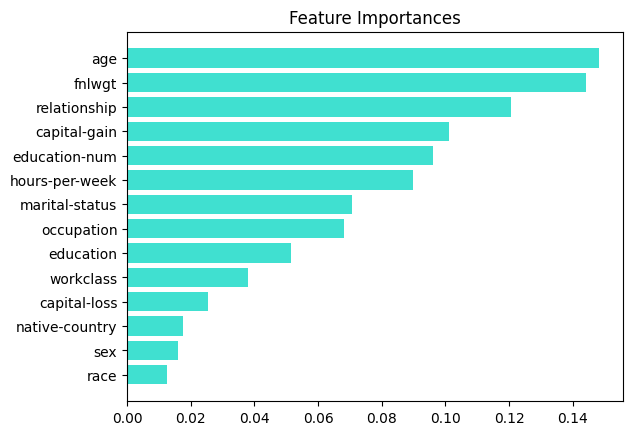

In [49]:
feature_names = list(featured_selection.columns)
feature_importances = rfc.feature_importances_
indices = np.argsort(feature_importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='turquoise', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [50]:
# Choosing the top 6 features, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

In [51]:
top_6_features = [feature_names[i] for i in indices]
top_6_features = top_6_features[:7:-1]

In [52]:
X_train_6 = X_train_set_small[top_6_features]
validation_set_top6 = validation_set[top_6_features]
y_validation_set_top6 = validation_set['annual-income']

# Scaled Training set for SVM
scaled_X_train_6 = scaler.fit_transform(X_train_6)
scaled_X_train_6 = pd.DataFrame(scaled_X_train_6, index = X_train_6.index, columns = X_train_6.columns)

# Scaled Validation for SVM 
scaled_X_valid_6 = scaler.fit_transform(validation_set_top6)
scaled_X_valid_6 = pd.DataFrame(scaled_X_valid_6, index = validation_set_top6.index, columns = validation_set_top6.columns)


In [53]:
gnb_six = GaussianNB()
gnb_six.fit(X_train_6, y_train_set_small)
gnb_y_pred_6 = gnb_six.predict(validation_set_top6)

In [54]:
SVM_model_six = SVC()
SVM_model_six.fit(scaled_X_train_6, y_train_set_small)
SVM_y_pred_6 = SVM_model_six.predict(scaled_X_valid_6)

In [55]:
rfc_six = RandomForestClassifier(random_state = 23730704)
rfc_six.fit(X_train_6, y_train_set_small)
rfc_y_pred_six = rfc_six.predict(validation_set_top6)

In [56]:
# Choosing the top 11 features, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

In [57]:
top_11_features = [feature_names[i] for i in indices]
top_11_features = top_11_features[:2:-1]

In [58]:
X_train_11 = X_train_set_small[top_11_features]
validation_set_top11 = validation_set[top_11_features]
y_validation_set_top11 = validation_set['annual-income']

# Scaled Training set for SVM
scaled_X_train_11 = scaler.fit_transform(X_train_11)
scaled_X_train_11 = pd.DataFrame(scaled_X_train_11, index = X_train_11.index, columns = X_train_11.columns)

# Scaled Validation for SVM 
scaled_X_valid_11 = scaler.fit_transform(validation_set_top11)
scaled_X_valid_11 = pd.DataFrame(scaled_X_valid_11, index = validation_set_top11.index, columns = validation_set_top11.columns)


In [59]:
gnb_eleven = GaussianNB()
gnb_eleven.fit(X_train_11, y_train_set_small)
gnb_y_pred_11 = gnb_eleven.predict(validation_set_top11)

In [60]:
SVM_model_eleven = SVC()
SVM_model_eleven.fit(scaled_X_train_11, y_train_set_small)
SVM_y_pred_11 = SVM_model_eleven.predict(scaled_X_valid_11)

In [61]:
rfc_eleven = RandomForestClassifier(random_state = 23730704)
rfc_eleven.fit(X_train_11, y_train_set_small)
rfc_y_pred_11 = rfc_eleven.predict(validation_set_top11)

# Compare the performance of the models with respect the algorithm used

Comparing the metrics for the the worst model is the one with only the top 6 features. This is most likely because of how eliminating more than half the data made it so the model could not accuracy predict. And it got a bit better for the top 11 and was the best for the original model in Part 1. This is true for both the NB and SVM and only RF being an exception since the Model in part one overfitted the data. 

We can see how the sensitivity goes up comparing the 6 to 11 and 11 to original. This shows how  Out of all the guesses it makes for being TP / TP + FN. Meaning out of all the guesses it makes compared to the guesses it made for either >50k and <50k

In [62]:
# NB
display(p1_metrics(y_train, gnb_y_pred))
display(p1_metrics(y_validation_set_top6,gnb_y_pred_6))
display(p1_metrics(y_validation_set_top11,gnb_y_pred_11))

{'auc': 0.7063650267163583,
 'f1': 0.5798001620307859,
 'accuracy': 0.8112566715186803,
 'sensitivity': 0.47290748898678414,
 'specificity': 0.9398225644459324,
 'precision': 0.7491277041172366,
 'confusion_matrix': array([[11229,   719],
        [ 2393,  2147]], dtype=int64)}

{'auc': 0.5927856336117768,
 'f1': 0.3341797866937532,
 'accuracy': 0.7615062761506276,
 'sensitivity': 0.21744877726371448,
 'specificity': 0.9681224899598394,
 'precision': 0.7214912280701754,
 'confusion_matrix': array([[3857,  127],
        [1184,  329]], dtype=int64)}

{'auc': 0.6429160959767689,
 'f1': 0.457220461747397,
 'accuracy': 0.7818810260141895,
 'sensitivity': 0.33377395902181095,
 'specificity': 0.9520582329317269,
 'precision': 0.7255747126436781,
 'confusion_matrix': array([[3793,  191],
        [1008,  505]], dtype=int64)}

In [63]:
# SVM
display(p1_metrics(standardize_y_train, SVM_y_pred))
display(p1_metrics(y_validation_set_top6, SVM_y_pred_6))
display(p1_metrics(y_validation_set_top11, SVM_y_pred_11))

{'auc': 0.7910942277033076,
 'f1': 0.7118972619336078,
 'accuracy': 0.8557738961669092,
 'sensitivity': 0.647136563876652,
 'specificity': 0.9350518915299632,
 'precision': 0.7910608508346796,
 'confusion_matrix': array([[11172,   776],
        [ 1602,  2938]], dtype=int64)}

{'auc': 0.759119010742242,
 'f1': 0.6613138686131387,
 'accuracy': 0.8311806439876296,
 'sensitivity': 0.5988103106411103,
 'specificity': 0.9194277108433735,
 'precision': 0.7383863080684596,
 'confusion_matrix': array([[3663,  321],
        [ 607,  906]], dtype=int64)}

{'auc': 0.7676651749098178,
 'f1': 0.6736462093862815,
 'accuracy': 0.8355466618155357,
 'sensitivity': 0.6166556510244547,
 'specificity': 0.9186746987951807,
 'precision': 0.7422434367541766,
 'confusion_matrix': array([[3660,  324],
        [ 580,  933]], dtype=int64)}

In [64]:
# RF
display(p1_metrics(y_train, rfc_y_pred))
display(p1_metrics(y_validation_set_top6,rfc_y_pred_six))
display(p1_metrics(y_validation_set_top11,rfc_y_pred_11))

{'auc': 0.9999581519919652,
 'f1': 0.9998898799691665,
 'accuracy': 0.9999393498301795,
 'sensitivity': 1.0,
 'specificity': 0.9999163039839304,
 'precision': 0.9997797841885048,
 'confusion_matrix': array([[11947,     1],
        [    0,  4540]], dtype=int64)}

{'auc': 0.7673675534922241,
 'f1': 0.6682842287694974,
 'accuracy': 0.825905039112243,
 'sensitivity': 0.637144745538665,
 'specificity': 0.8975903614457831,
 'precision': 0.7026239067055393,
 'confusion_matrix': array([[3576,  408],
        [ 549,  964]], dtype=int64)}

{'auc': 0.7925380470991699,
 'f1': 0.7069864442127215,
 'accuracy': 0.8466436237947972,
 'sensitivity': 0.6721744877726371,
 'specificity': 0.9129016064257028,
 'precision': 0.7456011730205279,
 'confusion_matrix': array([[3637,  347],
        [ 496, 1017]], dtype=int64)}

## Part 6: Final Models and Visualization

1. Using the full training set (**feature selection + training + validation**), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named `gnb_final`, `svm_final`, and `rf_final`.
2. Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.
3. Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.
4. Which of the above metrics best illuminate the difference (if any) in model performance? Why?

In [65]:
scaled_TrainAndValidation_set = scaler.fit_transform(TrainAndValidation) 
standardized_TrainAndValidation_set = pd.DataFrame(scaled_TrainAndValidation_set, index = TrainAndValidation.index, columns = TrainAndValidation.columns)

X_train = TrainAndValidation.drop(['annual-income'], axis=1)
y_train = TrainAndValidation['annual-income']

In [66]:
gnb_final = GaussianNB()
gnb_final.fit(X_train, y_train)
gnb_final_y_pred = gnb_final.predict(X_test)

In [67]:
svm_final = SVC()
svm_final.fit(standardize_X_train, standardize_y_train)
svm_final_y_pred = svm_final.predict(standardize_X_test)

In [68]:
rf_final = RandomForestClassifier(random_state = 23730704)
rf_final.fit(X_train, y_train)
rf_final_y_pred = rf_final.predict(X_test)

In [69]:
mean_names = []
for dict_items in collate_cv_results(nb_score).keys():
    if 'mean' in dict_items:
        mean_names.append(dict_items)
mean_names

std_names = []
for dict_items in collate_cv_results(nb_score).keys():
    if 'std' in dict_items:
        std_names.append(dict_items)
std_names

auc 0.711096570348996 (0.013032112915892187)
f1 0.5872089959129536 (0.022537694387729762)
accuracy 0.8123720718671821 (0.005895602181858433)
sensitivity 0.4857129208153907 (0.028984801624573717)
specificity 0.9364802198826012 (0.0030236553670671892)
precision 0.7437813279740275 (0.0035254037300442467)
auc 0.711096570348996 (0.013032112915892187)
f1 0.5872089959129536 (0.022537694387729762)
accuracy 0.8123720718671821 (0.005895602181858433)
sensitivity 0.4857129208153907 (0.028984801624573717)
specificity 0.9364802198826012 (0.0030236553670671892)
precision 0.7437813279740275 (0.0035254037300442467)


['auc_std',
 'f1_std',
 'accuracy_std',
 'sensitivity_std',
 'specificity_std',
 'precision_std']

In [70]:
# Means from Nb model 
nb_means=[]
nb_means.append(nb_mean['auc_mean'])
nb_means.append(nb_mean['f1_mean'])
nb_means.append(nb_mean['accuracy_mean'])
nb_means.append(nb_mean['sensitivity_mean'])
nb_means.append(nb_mean['specificity_mean'])
nb_means.append(nb_mean['precision_mean'])
nb_means

#Standardard Deviation for Nb model 
nb_std=[]
nb_std.append(nb_mean['auc_std'])
nb_std.append(nb_mean['f1_std'])
nb_std.append(nb_mean['accuracy_std'])
nb_std.append(nb_mean['sensitivity_std'])
nb_std.append(nb_mean['specificity_std'])
nb_std.append(nb_mean['precision_std'])

In [71]:
# Means from SVM model 
svm_means = []
svm_means.append(svm_mean['auc_mean'])
svm_means.append(svm_mean['f1_mean'])
svm_means.append(svm_mean['accuracy_mean'])
svm_means.append(svm_mean['sensitivity_mean'])
svm_means.append(svm_mean['specificity_mean'])
svm_means.append(svm_mean['precision_mean'])
svm_means

#Standardard Deviation for SVM model 
svm_std=[]
svm_std.append(svm_mean['auc_std'])
svm_std.append(svm_mean['f1_std'])
svm_std.append(svm_mean['accuracy_std'])
svm_std.append(svm_mean['sensitivity_std'])
svm_std.append(svm_mean['specificity_std'])
svm_std.append(svm_mean['precision_std'])

In [72]:
# Means from Rf model 
rf_means = []
rf_means.append(rf_mean['auc_mean'])
rf_means.append(rf_mean['f1_mean'])
rf_means.append(rf_mean['accuracy_mean'])
rf_means.append(rf_mean['sensitivity_mean'])
rf_means.append(rf_mean['specificity_mean'])
rf_means.append(rf_mean['precision_mean'])
rf_means

#Standardard Deviation for Nb model 
rd_std=[]
rd_std.append(rf_mean['auc_std'])
rd_std.append(rf_mean['f1_std'])
rd_std.append(rf_mean['accuracy_std'])
rd_std.append(rf_mean['sensitivity_std'])
rd_std.append(rf_mean['specificity_std'])
rd_std.append(rf_mean['precision_std'])

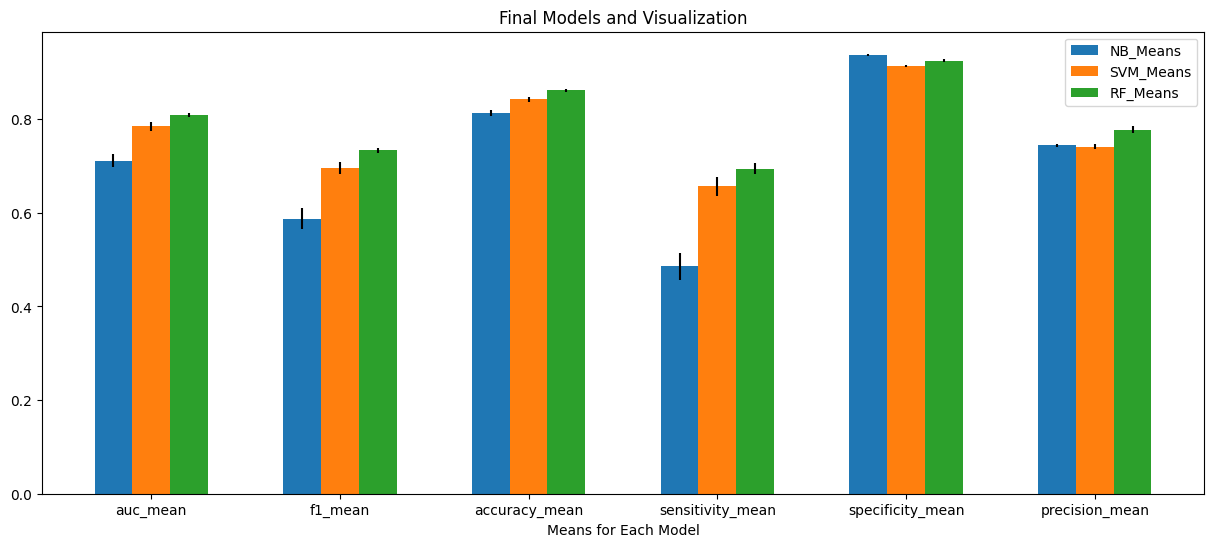

In [73]:
plt.figure(figsize=(15,6))
X_axis = np.arange(len(mean_names))

plt.bar(X_axis - 0.2, nb_means, 0.2, label = 'NB_Means', yerr=nb_std)
plt.bar(X_axis - 0.0, svm_means, 0.2, label = 'SVM_Means', yerr=svm_std)
plt.bar(X_axis - -0.2, rf_means, 0.2, label = 'RF_Means', yerr=rd_std)

plt.xticks(X_axis, mean_names)
plt.xlabel("Means for Each Model")
plt.title("Final Models and Visualization")
plt.legend()
plt.show()

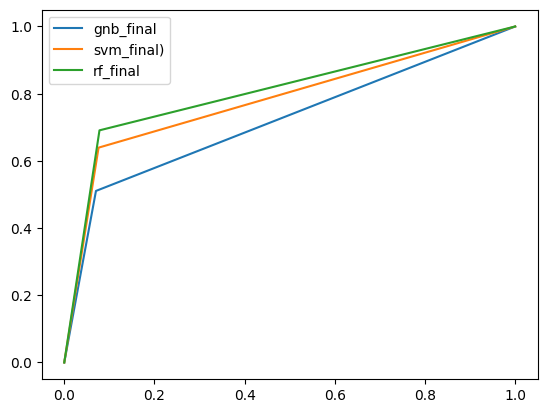

In [74]:
fpr, tpr, _ = metrics.roc_curve(y_test, gnb_final_y_pred)
plt.plot(fpr,tpr, label = "gnb_final")
fpr, tpr, _ = metrics.roc_curve(standardize_y_test, svm_final_y_pred)
plt.plot(fpr,tpr, label = "svm_final)")
fpr, tpr, _ = metrics.roc_curve(y_test, rf_final_y_pred)
plt.plot(fpr,tpr, label = "rf_final")
plt.legend()


# Which of the above metrics best illuminate the difference (if any) in model performance? Why?

Looking at the metrics recording for the means in each model and the ROC graph we can see that how the the NB model consisntaly performed worse thatn the other two models. This most likely because the model used for the NB metric was from part one where the data was underfitted the model meaning it would report worse all across the board. We can see for every blue bar it reported the lowest data. And the inverse is true for the RF model. After training using the hyperparameters it became the most consistant model we used in this project. And the SVM was around average not too far off in the RF overall.

One part where the NB model did outshine the others is for specificity mean, meaning for the data it guessed it had the greatest perdictions for true negatives. However when looking at Sensitvity we can see it falls extreamly short meaning it fails to get true positive.

Comparably the RF and SVM models the RF model reports better metrics. This may be due to the hyperparamater tuning we did. Overall they were very close but the RF model seems to be more consistant outshining the SVM in every way. 

Using the ROF graph we can see how the NB model is lagging behind the RF and SVM. There is only a minor difference in the RF and SVM model but overall the RF is better in every way. 

## Part 7: Holdout Set Evaluation (Instructor)

Your final models `gnb_final`, `svm_final`, and `rf_final` will be evaluated on a holdout set by the instructor.

In [75]:
# hi professor